In [1]:
import json
import csv
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
#Se lee la data entera
with open('../data/subreddits.json', 'r') as file:
    data = json.load(file)

In [3]:
#Dataframe para los subreddits
subreddit_data = pd.DataFrame({
    'subreddit_id': range(len(data)),  #Se crea un id para cada subreddit
    'tittleSubreddit': [sub['tittleSubreddit'] for sub in data],
    'subscribersReddit': [sub['subscribersReddit'] for sub in data],
    'descriptionReddit': [sub['descriptionReddit'] for sub in data],
    'createdReddit': [sub['createdReddit'] for sub in data],
})

#Dataframe para los posts
posts_data = []
for i, sub in enumerate(data):
    for post in sub['upVotedPosts']:
        posts_data.append({
            'subreddit_id': i,  #foreign key
            'titlePost': post['titlePost'],
            'selftext': post['selftext'],
            'createdPost': post['createdPost'],
            'scorePost': post['scorePost'],
            'upVotedRatio': post['upVotedRatio'],
            'upVotes': post['upVotes'],
            'commentsPost': post['commentsPost'],
        })

posts_data = pd.DataFrame(posts_data)

In [4]:
len(subreddit_data), len(posts_data)

(200, 199753)

In [5]:
subreddit_data.head()

,subreddit_id,tittleSubreddit,subscribersReddit,descriptionReddit,createdReddit
0,0,Home,256578,,1.232850e+09
1,1,AskReddit,49156092,r/AskReddit is the place to ask and answer tho...,1.201233e+09
2,2,NoStupidQuestions,5101877,Ask away!\n\nDisclaimer: This is an anonymous ...,1.359795e+09
3,3,BaldursGate3,2584367,"A community all about Baldur's Gate III, the r...",1.559227e+09
4,4,facepalm,8226774,/r/facepalm - please sir can I have some more?,1.251449e+09


In [6]:
posts_data.head()

,subreddit_id,titlePost,selftext,createdPost,scorePost,upVotedRatio,upVotes,commentsPost
0,0,Those mortgage rates ...,,1.713931e+09,22162,0.97,22162,1655
1,0,My parents bought the house 6 months ago after...,Any idea for next steps and what their options...,1.715981e+09,19061,0.89,19061,5813
2,0,What is this stuff coming out from my balls?,I’ve noticed something strange in my garage—st...,1.727928e+09,8139,0.95,8139,1643
3,0,"$16,000 for 8 Pella windows. Would you be ok w...",,1.724790e+09,3537,0.98,3537,1739
4,0,Basement floor leak,Got quite a few of these leaks in the basement...,1.721152e+09,1870,0.98,1870,569


**Procesamiento subreddits**

In [7]:
#Cambiamos el formato de las fechas en posts_data a datetime
posts_data['createdPost'] = pd.to_datetime(posts_data['createdPost'], unit='s')
subreddit_data['createdReddit'] = pd.to_datetime(subreddit_data['createdReddit'], unit='s')

posts_data = posts_data[~((posts_data['createdPost'].dt.year == 2024) & (posts_data['createdPost'].dt.month == 11))]
subreddit_data = subreddit_data[~((subreddit_data['createdReddit'].dt.year == 2024) & (subreddit_data['createdReddit'].dt.month == 11))]
posts_data = posts_data[~((posts_data['createdPost'].dt.year == 2023) & (posts_data['createdPost'].dt.month == 11))]
subreddit_data = subreddit_data[~((subreddit_data['createdReddit'].dt.year == 2023) & (subreddit_data['createdReddit'].dt.month == 11))]
#Debido a que pocos registros tienen la descripción vacía, se puede asumir su uso.
numNulls = (subreddit_data["descriptionReddit"] == "").sum()
numNulls 

np.int64(5)

***Procesamiento posts***

In [8]:
#Se elimina la columna 'selftext' debido alto porcentage de vacios
numNulls = (posts_data["selftext"] == "").sum()
percentage = numNulls / len(posts_data["selftext"]) * 100

print("Total de registros en la columna 'selftext':", len(posts_data["selftext"]))
print("Porcentaje de registros vacios en la columna 'selftext':", percentage, "%")
posts_data = posts_data.drop(columns=["selftext"])

Total de registros en la columna 'selftext': 182684
Porcentaje de registros vacios en la columna 'selftext': 62.99183289176939 %


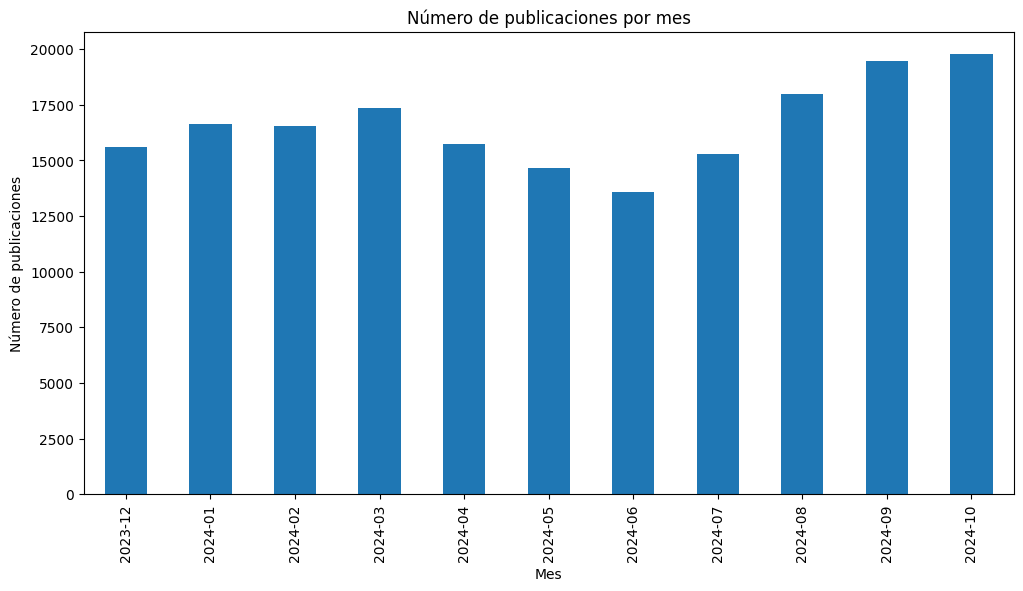

In [9]:
postsMonth = posts_data['createdPost'].dt.to_period('M').value_counts().sort_index()
date_range = pd.period_range(start=postsMonth.index.min(), end=postsMonth.index.max(), freq='M')
postsMonth = postsMonth.reindex(date_range, fill_value=0)

plt.figure(figsize=(12, 6))
postsMonth.plot(kind='bar')
plt.title('Número de publicaciones por mes')
plt.xlabel('Mes')
plt.ylabel('Número de publicaciones')
plt.show()

In [10]:
subreddit_data.head()
len(posts_data)

182684

In [11]:
subreddit_data.to_csv('../data/subreddit_data.csv', index=False)
posts_data.to_csv('../data/posts_data.csv', index=False)